<a href="https://colab.research.google.com/github/nereosky/DeepL-YuGiOh/blob/main/Yu_Gi_Oh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Deep learning YuGiOh


## Environnement matériel et logiciel

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.9 MB/s 
     |████████████████████████████████| 189 kB 50.0 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 1.2 MB 49.4 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 273 kB/s 
Mounted at /content/gdrive


In [6]:
!unrar x gdrive/My\ Drive/Kaggle/YuGiOhTrier.rar

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Extracting  Carte/monstresE/18601.jpg                                     42%  OK 
Extracting  Carte/monstresE/18602.jpg                                     42%  OK 
Extracting  Carte/monstresE/18603.jpg                                     42%  OK 
Extracting  Carte/monstresE/18605.jpg                                     42%  OK 
Extracting  Carte/monstresE/18607.jpg                                     42%  OK 
Extracting  Carte/monstresE/18608.jpg                                     42%  OK 
Extracting  Carte/monstresE/18609.jpg                                     42%  OK 
Extracting  Carte/monstresE/18610.jpg                                     42%  OK 
Extracting  Carte/monstresE/18611.jpg                                     42%  OK 
Extracting  Carte/monstresE/18613.jpg                                     42%  OK 
Ex

In [7]:
pip install split-folders

In [8]:
from fastbook import *
from fastai.vision.widgets import *

In [9]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
import splitfolders 

# Deep Learning Librairies
import keras.preprocessing.image as kpi

# Visualisaiton des données
from matplotlib import pyplot as plt

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4936804169895360923
xla_global_id: -1
]


In [11]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Prise en charge des données

### Structure des données

original
  - original
  - pictures
    - 15967
    - 15968
    - 15...
    - .....
  - cards.csv

### Création d'un jeu d'apprentissage et de validation

In [15]:
data_dir = '/content/Carte/' # chemin d'accès aux données

### Illustration des données

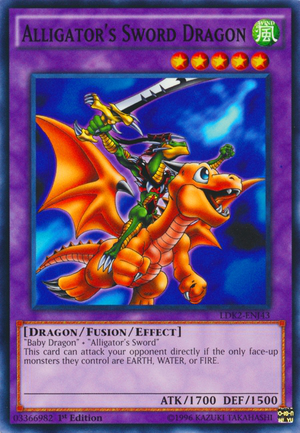

In [18]:
img = kpi.load_img(data_dir+'fusion/16045.jpg')  # this is a PIL image
img

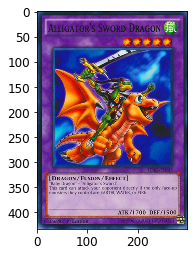

In [19]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

### Pré-traitements

In [20]:
test = get_image_files(data_dir)
failed = verify_images(test)
failed

(#0) []

In [22]:
splitfolders.ratio("/content/Carte/", output="split", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 8529 files [00:13, 648.04 files/s]


### Training my Model

In [33]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,val = add_props(lambda i,self: self[i])

In [40]:
carte = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [41]:
dls = carte.dataloaders("split")

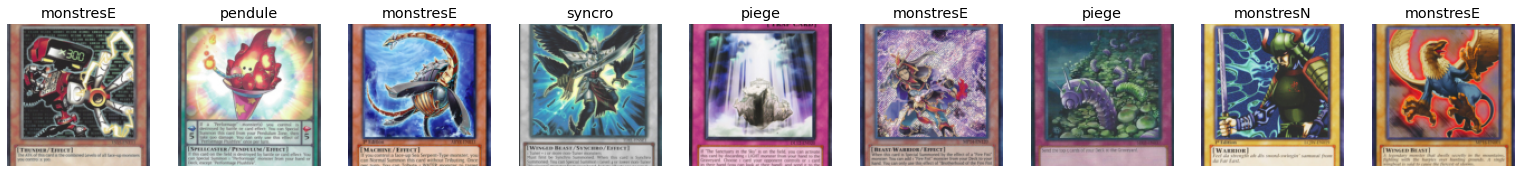

In [42]:
dls.valid.show_batch(max_n=9, nrows=1)

In [43]:
carte = carte.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = carte.dataloaders("split")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [44]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.180504,0.452023,0.117276,31:31


epoch,train_loss,valid_loss,error_rate,time
0,0.465181,0.274492,0.057736,44:12
1,0.338858,0.264581,0.058187,43:16
2,0.243724,0.224383,0.055029,43:48
3,0.225628,0.222057,0.052323,42:44


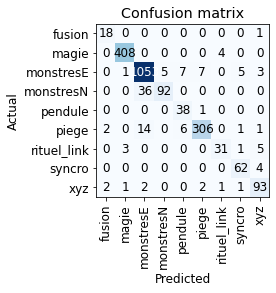

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [50]:
learn.export()

## Test du model

In [51]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from google.colab import files

In [52]:
learn_inf = load_learner("/content/gdrive/MyDrive/Kaggle/export.pkl")
img = null
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
pred,pred_idx,probs = null,null,null
lbl_pred = widgets.Label()
lbl_pred.value = ""
btn_run = widgets.Button(description='Classify')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Ajouter une carte Yu-Gi-Oh'), 
      btn_upload, btn_run, out_pl, lbl_pred])